## Generate and Visualize Data

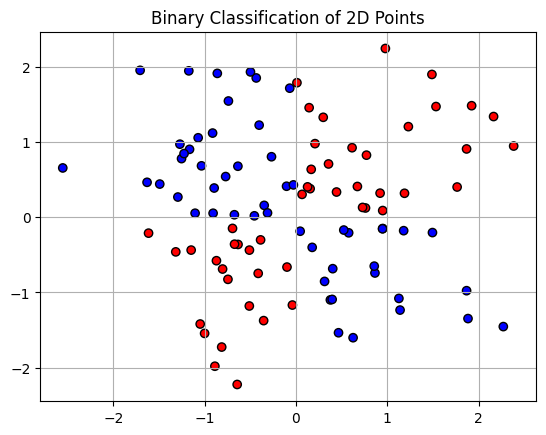

In [1]:
import numpy as np
# A plotting library to visualize the 2d data
import matplotlib.pyplot as plt

# Random number generation is deterministic if you fix the seed
np.random.seed(0)

# X is a NumPy array of shape (100, 2)
# 100 samples with 2 features (x1, x2) from a standard normal distribution
X = np.random.randn(100, 2)

# Get first and second coordinates
x1 = X[:, 0]
x2 = X[:, 1]
# Create boolean array: True if product > 0, else False
same_sign = x1 * x2 > 0
# Convert booleans to integers
labels = same_sign.astype(int)
# Reshape into column vector (100, 1) instead of flat array
y = labels.reshape(-1, 1)

# Plot points colored by label
plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), cmap='bwr', edgecolors='k')
plt.title("Binary Classification of 2D Points")
plt.grid(True)
plt.show()

## Neural Network Architecture (2 → 4 → 1)

This diagram shows the structure of our neural network before training begins.
- 2 input features
- 4 hidden layer neurons (weights `W1` and biases `b1`)
- 1 output neuron (weights `W2` and bias `b2`)


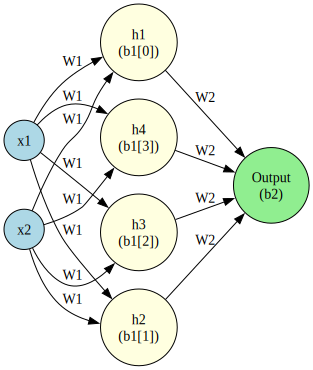

In [2]:
from graphviz import Digraph
nn_arch = Digraph(format='png')
nn_arch.attr(rankdir='LR', size='8')

# input layer
nn_arch.node('x1', 'x1', shape='circle', style='filled', fillcolor='lightblue')
nn_arch.node('x2', 'x2', shape='circle', style='filled', fillcolor='lightblue')

# hidden layer
for i in range(1, 5):
    nn_arch.node(f'h{i}', f'h{i}\n(b1[{i-1}])', shape='circle', style='filled', fillcolor='lightyellow')

# output layer
nn_arch.node('y', 'Output\n(b2)', shape='circle', style='filled', fillcolor='lightgreen')

# edges from inputs to hidden layer (with W1 labels)
for xi in ['x1', 'x2']:
    for i in range(1, 5):
        nn_arch.edge(xi, f'h{i}', label='W1')

# edges from hidden to output (with W2 labels)
for i in range(1, 5):
    nn_arch.edge(f'h{i}', 'y', label='W2')

nn_arch.render('nn_architecture', view=False)
nn_arch

## Initialize Network Weights

In [3]:
np.random.seed(0)

# Input layer -> Hidden layer (2 -> 4)
W1 = np.random.randn(2, 4)      # 2 weights (two input features) per hidden neuron
b1 = np.zeros((1, 4))           # 1 bias per hidden neuron

# Hidden layer -> Output layer (4 -> 1)
W2 = np.random.randn(4, 1)      # 4 hidden outputs connected to 1 output node
b2 = np.zeros((1, 1))           # 1 bias for the 1 output neuron

print("Initial W1:\n", W1)
print("Initial b1:\n", b1)
print("Initial W2:\n", W2)
print("Initial b2:\n", b2)

Initial W1:
 [[ 1.76405235  0.40015721  0.97873798  2.2408932 ]
 [ 1.86755799 -0.97727788  0.95008842 -0.15135721]]
Initial b1:
 [[0. 0. 0. 0.]]
Initial W2:
 [[-0.10321885]
 [ 0.4105985 ]
 [ 0.14404357]
 [ 1.45427351]]
Initial b2:
 [[0.]]


## Forward Propagation
Pass the input data through the network to get predictions
- Compute values for the hidden layer using weights and biases, then apple ReLU
- Pass those through the output layer and apply sigmoid to get probabilities
### Additional Notes
- @ (matrix multiplication): dot product between two matrices

In [4]:
# Activation functions to add non-linearity to the network
def relu(x):
    # sets negative values to 0
    return np.maximum(0, x)

def sigmoid(x):
    # maps values to range (0, 1)
    return 1 / (1 + np.exp(-x))

# Forward pass through the network
# Layer 1: Input -> Hiddem
Z1 = X @ W1 + b1    # (100, 2) @ (2, 4) + (1, 4) -> (100, 4)
A1 = relu(Z1)       # filter out negative values

# Layer 2: Hidden -> Output
Z2 = A1 @ W2 + b2   # (100, 4) @ (4, 1) + (1, 1) -> (100, 1)
A2 = sigmoid(Z2)    # output a probability between 0 and 1

print("First 5 rows of Z1:\n", Z1[:5])
print("First 5 rows of A1:\n", A1[:5])
print("First 5 predicted probabilities (A2):\n", A2[:5])

First 5 rows of Z1:
 [[ 3.85919747  0.31483347  2.10672977  3.89248623]
 [ 5.91154304 -1.7983263   3.08697472  1.85407195]
 [ 1.46934694  1.70238885  0.89934955  4.33291605]
 [ 1.39333734  0.52810278  0.78608489  2.15195568]
 [ 0.58473306 -0.4425726   0.28908067 -0.29344947]]
First 5 rows of A1:
 [[3.85919747 0.31483347 2.10672977 3.89248623]
 [5.91154304 0.         3.08697472 1.85407195]
 [1.46934694 1.70238885 0.89934955 4.33291605]
 [1.39333734 0.52810278 0.78608489 2.15195568]
 [0.58473306 0.         0.28908067 0.        ]]
First 5 predicted probabilities (A2):
 [[0.99664896]
 [0.92627327]
 [0.99906882]
 [0.96496628]
 [0.49532132]]


## Loss Calculation
- Now that we have predicted probabilites (A2), we need to measure how far off these predictions are from the true labels (y).
- We use Binary Cross-Entropy Loss, which compares each predicted probability to the actual label (0 or 1). Lower loss means better predictions.

In [5]:
# Computes binary cross-entropy loss
def compute_loss(y_true, y_pred):
    # y_true: array of true binary labels (0 or 1)
    # y_pred: array of predicted probabilities (between 0 and 1)

    # to avoid log(0)
    epsilon = 1e-8
    
    # Compute log of predicted probabilities
    # Log penalizes wrong, confident predictions more and rewards correct ones

    # First term: y * log(p) for true positives (label = 1)
    # y_true = 1: becomes log(y_pred)
    # y_true = 0: becomes 0
    term1 = y_true * np.log(y_pred + epsilon)

    # Second term: (1 - y) * log(1 - p) for true negatives (label = 0)
    # y-true = 1: becomes 0
    # y-true = 0: becomes log(1 - y_pred)
    term2 = (1 - y_true) * np.log(1 - y_pred + epsilon)

    # Combine both terms
    # Add because only one term is active per sample
    total_loss_per_sample = term1 + term2
    # Take the mean across all sample and negate
    # mean: we want a single loss value
    # negate: logarithms of probabilities are always negative
    loss = -np.mean(total_loss_per_sample)
    return loss

# Compute the loss for the current predictions
loss = compute_loss(y, A2)
print("Final Loss:", loss)



Final Loss: 1.1435596291463497


## Backpropagation (Gradient Calculation)
- Now that we have the loss, we use backpropagation to calculate how much each weight and bias contributed to the error.
- This involves computing the gradients (slopes) of the loss with respect to each parameter, which we’ll use in the next step to update them using gradient descent.
### Math Involved
1. Output Layer Gradient: 
- The derivative of binary cross-entropy loss with respect to the pre-activation (Z2) simplifies to just the difference between predicted probability and true label.
    - Loss: L = -[y·log(σ(z)) + (1-y)·log(1-σ(z))]
        - Where σ(z) = 1/(1+e^(-z)) is sigmoid
    - Result (dZ2): ∂L/∂z = σ(z) - y = A2 - y
2. Output Layer Weight Gradients:
- For weights (dW2): ∂L/∂W2 = ∂L/∂Z2 · ∂Z2/∂W2 = dZ2 · A1
- For biases (db2): ∂L/∂b2 = ∂L/∂Z2 · ∂Z2/∂b2 = dZ2 · 1
3. Backpropagating to Hidden Layer
- Result (dA1): ∂L/∂A1 = ∂L/∂Z2 · ∂Z2/∂A1 = dZ2 · W2
4. Hidden Layer Activation Gradient
- ReLU(z) = max(0, z)
- ∂ReLU/∂z = 1 if z > 0, else 0
5. Hidden Layer Weight Gradients
- For weights (dW1): ∂L/∂W1 = ∂L/∂Z1 · ∂Z1/∂W1 = dZ1 · X
- For biases (db2): ∂L/∂b1 = ∂L/∂Z1 · ∂Z2/∂b1 = dZ1 · 1

In [6]:
# This diagram shows how data moves forward through the network
# and how gradients flow backward using the chain rule during training.
from graphviz import Digraph

g = Digraph(format='png')
g.attr(rankdir='LR', size='10')

# Forward pass nodes
g.node('X', 'X (Input)', shape='ellipse')
g.node('Z1', 'Z1 = X·W1 + b1', shape='box')
g.node('A1', 'A1 = ReLU(Z1)', shape='box')
g.node('Z2', 'Z2 = A1·W2 + b2', shape='box')
g.node('A2', 'A2 = Sigmoid(Z2)', shape='box')
g.node('L', 'Loss = BCE(A2, y)', shape='diamond')

# Forward arrows
g.edge('X', 'Z1', label='W1, b1')
g.edge('Z1', 'A1')
g.edge('A1', 'Z2', label='W2, b2')
g.edge('Z2', 'A2')
g.edge('A2', 'L', label='Compare with y')

# Backward pass arrows
g.edge('L', 'A2', label='dL/dA2', style='dashed')
g.edge('A2', 'Z2', label='dZ2 = A2 - y', style='dashed')
g.edge('Z2', 'A1', label='dA1 = dZ2·W2ᵀ', style='dashed')
g.edge('A1', 'Z1', label='dZ1 = dA1·ReLU\'', style='dashed')
g.edge('Z1', 'X', label='dW1 = Xᵀ·dZ1', style='dashed')

g.render('nn_backprop_flow', view=True)
g

### Additional Notes
- .T (transpose)
    - used to align matrix dimensions for correct multiplication
    - for example, A1.T flips shape from (100, 4) to (4, 100) so it can multiply with dZ2 (100, 1).
- dividing by len(X)
    - average the gradients over all training examples
    - makes training stable and consistent regardless of batch size
- np.mean for biases
    - take the mean because bias represents a constant offset that should be adjusted based on the average error
    - axis=0: takes the mean along the first dimension (rows)
        - average across samples but keeps neurons seperate
    - keepdims=True: preserves the original number of dimensions
        - keeps the collapsed dimension as size 1

In [7]:
# 1. output layer gradient
dZ2 = A2 - y

# 2. output layer weight gradients
dW2 = A1.T @ dZ2 / len(X)
db2 = np.mean(dZ2, axis=0, keepdims=True)

# 3. backpropagating to hidden layer
dA1 = dZ2 @ W2.T

# 4. hidden layer activation gradient
dZ1 = dA1 * (Z1 > 0)

# 5. hidden layer weight gradients
dW1 = X.T @ dZ1 / len(X)
db1 = np.mean(dZ1, axis=0, keepdims=True)

print("dW1 shape:", dW1.shape)
print("db1 shape:", db1.shape)
print("dW2 shape:", dW2.shape)
print("db2 shape:", db2.shape)

dW1 shape: (2, 4)
db1 shape: (1, 4)
dW2 shape: (4, 1)
db2 shape: (1, 1)


## Parameter Update
- Now that we've calculated the gradients from backpropagation, we apply gradient descent to update the weights and biases.
- This moves the parameters in the direction that reduces the loss, making the model better at predicting
### Additional Notes
- Learning rate: used to control how big a step we take in the direction of the gradient during each parameter update
    - chosen through experimentation
        - too slow means slow learning
        - too large can cause the model to overshoot
- parameter = parameter - learning_rate * gradient
    - subtracting the gradient moves the model's parameters in the direction that minimizes the loss

In [8]:
# Step size
learning_rate = 0.1

# Update weights and biases
W1 -= learning_rate * dW1
b1 -= learning_rate * db1
W2 -= learning_rate * dW2
b2 -= learning_rate * db2

print("Updated W1:\n", W1)
print("Updated b1:\n", b1)
print("Updated W2:\n", W2)
print("Updated b2:\n", b2)

Updated W1:
 [[ 1.76482252  0.39113085  0.97742582  2.21683224]
 [ 1.86743588 -0.97392308  0.95048837 -0.12559878]]
Updated b1:
 [[ 0.00131087 -0.00482247 -0.00190014 -0.02126667]]
Updated W2:
 [[-0.11417205]
 [ 0.39381683]
 [ 0.13776581]
 [ 1.41451704]]
Updated b2:
 [[-0.02062637]]
